#Importando as bibliotecas

In [5]:
from torchvision.datasets import CelebA
from torchvision import transforms
from torch.utils.data import DataLoader, Subset
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

#Baixando o dataset

In [2]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

celeba = CelebA(
    root='data/celeba',
    split='all',
    target_type='attr',
    transform=transform,
    download=True
)

Downloading...
From (original): https://drive.google.com/uc?id=0B7EVK8r0v71pZjFTYXZWM3FlRnM
From (redirected): https://drive.usercontent.google.com/download?id=0B7EVK8r0v71pZjFTYXZWM3FlRnM&confirm=t&uuid=f02ee31d-1553-45fd-a211-24532420fa60
To: /content/data/celeba/celeba/img_align_celeba.zip
100%|██████████| 1.44G/1.44G [00:20<00:00, 71.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=0B7EVK8r0v71pblRyaVFSWGxPY0U
To: /content/data/celeba/celeba/list_attr_celeba.txt
100%|██████████| 26.7M/26.7M [00:00<00:00, 79.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1_ee_0u7vcNLOfNLegJRHmolfH5ICW-XS
To: /content/data/celeba/celeba/identity_CelebA.txt
100%|██████████| 3.42M/3.42M [00:00<00:00, 174MB/s]
Downloading...
From: https://drive.google.com/uc?id=0B7EVK8r0v71pbThiMVRxWXZ4dU0
To: /content/data/celeba/celeba/list_bbox_celeba.txt
100%|██████████| 6.08M/6.08M [00:00<00:00, 16.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=0B7EVK8r0v71pd0FJY3Blby1HUTQ
To: /con

Separando só as imagens com rótulo de gênero

In [3]:
#celeba.attr é um tensor [N × 40], índice 20 = "Male" (0 = feminino, 1 = masculino)
labels = celeba.attr[:, 20]

# 4. Criando um DataLoader para interar com modelo no treinamento
loader = DataLoader(
    celeba,
    batch_size=64,
    shuffle=True,
    num_workers=4
)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


# **MOBILENET V2**

In [6]:
model = models.mobilenet_v2(pretrained=True)
#ajustando o classificador final para 2 classes (feminino / masculino)

model.classifier[1] = nn.Linear(model.last_channel, 2)
model = model.cuda()

#Loss e Otimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 62.6MB/s]


**Treinamento para classificar duas classes Feminino ou Masculino**

In [8]:
def get_gender_labels(attributes):
    return attributes[:, 20].long()  # 0 ou 1

#Loop de treinamento por 10 épocas
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, attributes in loader:
        images = images.cuda()
        labels = get_gender_labels(attributes).cuda()
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(loader.dataset)
    print(f'Época {epoch+1}/{num_epochs} — Loss: {epoch_loss:.4f}')

print("Treino concluído!")

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Época 1/10 — Loss: 0.0592
Época 2/10 — Loss: 0.0343
Época 3/10 — Loss: 0.0238
Época 4/10 — Loss: 0.0168
Época 5/10 — Loss: 0.0116
Época 6/10 — Loss: 0.0095
Época 7/10 — Loss: 0.0086
Época 8/10 — Loss: 0.0069
Época 9/10 — Loss: 0.0064
Época 10/10 — Loss: 0.0057
Treino concluído!


In [9]:
#Salvando os pesos depois do Treinamento
save_path = 'mobilenet_gender.pth'
torch.save(model.state_dict(), save_path)
print(f'Pesos salvos em: {save_path}')

Pesos salvos em: mobilenet_gender.pth


In [48]:
#Instalações
!pip install retina-face
!pip install torch torchvision pillow

In [92]:
#Bibliotecas
import cv2
from retinaface import RetinaFace
import numpy as np
from google.colab.patches import cv2_imshow

**Carregando as imagens**

In [93]:
#caminhos das duas imagens
img_path = "/content/homem.jpg"
img_path_2 = "/content/mulher.jpg"

img = cv2.imread(img_path)
img_2 = cv2.imread(img_path_2)

In [94]:
#Detecção das faces
face = RetinaFace.detect_faces(img_path)
face_2 = RetinaFace.detect_faces(img_path_2)

**Desenhando a caixa na primeira imagem**

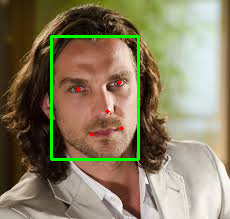

In [95]:
for face_id, face_data in face.items():
    x1, y1, x2, y2 = face_data["facial_area"]
    cv2.rectangle(img, (x1, y1), (x2, y2), (0,255,0), 2)
    for key, (x, y) in face_data["landmarks"].items():
        cv2.circle(img, (int(x), int(y)), 2, (0,0,255), -1)

cv2_imshow(img)

**Desenhando a caixa na segunda imagem**

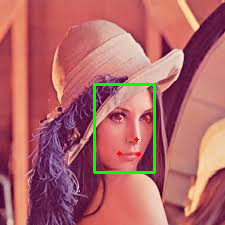

In [96]:
for face_id, face_data in face_2.items():
    x1, y1, x2, y2 = face_data["facial_area"]
    cv2.rectangle(img_2, (x1, y1), (x2, y2), (0,255,0), 2)
    for key, (x, y) in face_data["landmarks"].items():
        cv2.circle(img_2, (int(x), int(y)), 2, (0,0,255), -1)

cv2_imshow(img_2)

**Salvando as imagens com a caixa desenhada**

In [97]:
output_path = "/content/homem_annotated.jpg"
cv2.imwrite(output_path, img)
print(f"Primeira Imagem salva em: {output_path}")

Primeira Imagem salva em: /content/homem_annotated.jpg


In [98]:
output_path_2 = "/content/mulher_annotated.jpg"
cv2.imwrite(output_path_2, img_2)
print(f"Segunda Imagem salva em: {output_path_2}")

Segunda Imagem salva em: /content/mulher_annotated.jpg


Carregando o **MOBILENET V2** novamente

In [99]:
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"

In [100]:
model = models.mobilenet_v2(pretrained=False)
model.classifier[1] = torch.nn.Linear(model.last_channel, 2)
model = model.to(device)


# Carregando os pesos treinados

In [101]:
state_dict = torch.load("/content/mobilenet_gender.pth", map_location=device)
model.load_state_dict(state_dict)
model.eval()


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [102]:
#Preprocessamento esperado pelo modelo
preprocess = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std= [0.229, 0.224, 0.225]
    )
])

**Primeira Imagem**

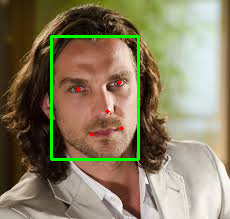

In [103]:
cv2_imshow(img)

In [104]:
img_path = "/content/homem_annotated.jpg"
img = Image.open(img_path).convert("RGB")

input_tensor = preprocess(img).unsqueeze(0).to(device)

**Predição para a primeira imagem**

In [87]:
with torch.no_grad():
    logits = model(input_tensor)
    probs  = torch.softmax(logits, dim=1)
    pred_idx = torch.argmax(probs, dim=1).item()

classes = ["feminino", "masculino"]
print(f"Predito: {classes[pred_idx]} (probabilidade: {probs[0,pred_idx]*100:.2f}%)")

Predito: masculino (probabilidade: 71.83%)


**Segunda imagem**

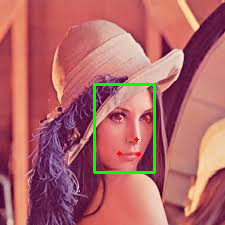

In [106]:
cv2_imshow(img_2)

In [88]:
img_path_2 = "/content/mulher_annotated.jpg"
img_2 = Image.open(img_path_2).convert("RGB")

input_tensor = preprocess(img_2).unsqueeze(0).to(device)

**Predição para a segunda imagem**

In [89]:
with torch.no_grad():
    logits = model(input_tensor)
    probs  = torch.softmax(logits, dim=1)
    pred_idx = torch.argmax(probs, dim=1).item()

classes = ["feminino", "masculino"]
print(f"Predito: {classes[pred_idx]} (probabilidade: {probs[0,pred_idx]*100:.2f}%)")

Predito: feminino (probabilidade: 82.11%)
